# After sales text clustering using TF-IDF and KMeans

## Data preprocessing (Merging the translated text)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
def query_data(query):
    """
    Function to query data from the database using sqlalchemy
    :param query:
    :return: pd.DataFrame

    Connection parameters:
    user = readmyzone
    password = (get from environment variable MYSQL_PASSWORD)
    host = 192.168.2.7
    port = 3306
    """

    # Create the connection string
    user = "readmyzone"
    password = os.environ.get("MYSQL_PASSWORD")
    host = "192.168.2.7"
    port = "3306"
    db = "myzone"
    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}"

    # Create the engine
    engine = create_engine(connection_string)

    try:
        # Query the data
        data = pd.read_sql(query, engine)
    except Exception as e:
        print(e)
        data = None

    return data

# Load the data

In [3]:
sav_incidencias = query_data("SELECT * FROM sav_incidencias")
sav_piezas = query_data("SELECT * FROM sav_piezas")
sav_estados = query_data("SELECT * FROM sav_estados")
sav_incidencias_tipo = query_data("SELECT * FROM sav_incidencias_tipo")

In [4]:
dataset = sav_incidencias.merge(
    sav_piezas,
    left_on="codigo",
    right_on="codigo_incidencia",
    how="left",
    suffixes=(None, "_pieza"),
)
dataset = dataset.merge(
    sav_estados, left_on="estado", right_on="id", how="left", suffixes=(None, "_estado")
)
dataset = dataset.merge(
    sav_incidencias_tipo,
    left_on="tipo",
    right_on="id",
    how="left",
    suffixes=(None, "_tipo"),
)

In [5]:
clean_dataset = dataset[(dataset["tipo"] == 1) & (dataset["estado"].isin([2, 6]))]

In [6]:
# Load from disk the text to translate dictionary
fields_to_translate = ["desc_problema", "problema", "descripcion"]
text_to_translate = {}
for text in fields_to_translate:
    text_to_translate[text] = pd.read_csv(
        f"../DATA/{text}.csv", sep="¬", encoding="utf-8-sig"
    )

C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\1709896185.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(
C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\1709896185.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(
C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\1709896185.py:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_translate[text] = pd.read_csv(


In [7]:
desc_problema_translated = pd.read_csv(
    "../DATA/desc_problema_translated.csv",
    sep="¬",
    encoding="utf-8-sig",
    engine="python",
)
descripcion_translated = pd.read_csv(
    "../DATA/descripcion_translated.csv", sep="¬", encoding="utf-8-sig", engine="python"
)
problema_translated = pd.read_csv(
    "../DATA/problema_translated.csv", sep="¬", encoding="utf-8-sig", engine="python"
)  # Data preprocessing (Merging the translated text)

In [8]:
# Delete rows with values (desc_problema, desc_problema_translated)
desc_problema_translated = desc_problema_translated[
    ~desc_problema_translated["desc_problema_translated"].isin(
        ["desc_problema_translated"]
    )
]
descripcion_translated = descripcion_translated[
    ~descripcion_translated["descripcion_translated"].isin(["descripcion_translated"])
]
problema_translated = problema_translated[
    ~problema_translated["problema_translated"].isin(["problema_translated"])
]

In [9]:
desc_problema_translated.count()

desc_problema               18099
desc_problema_translated    18099
dtype: int64

In [10]:
# Merge the translated text with the text_to_translate dataframe
desc_problema_translated = text_to_translate["desc_problema"].merge(
    desc_problema_translated,
    left_on="desc_problema",
    right_on="desc_problema",
    how="left",
)
descripcion_translated = text_to_translate["descripcion"].merge(
    descripcion_translated, left_on="descripcion", right_on="descripcion", how="left"
)
problema_translated = text_to_translate["problema"].merge(
    problema_translated, left_on="problema", right_on="problema", how="left"
)

In [11]:
# Fill NA with the original texts
desc_problema_translated.fillna(
    {"desc_problema_translated": desc_problema_translated["desc_problema"]},
    inplace=True,
)
descripcion_translated.fillna(
    {"descripcion_translated": descripcion_translated["descripcion"]}, inplace=True
)
problema_translated.fillna(
    {"problema_translated": problema_translated["problema"]}, inplace=True
)

In [12]:
desc_problema_translated.head(5)

,desc_problema,desc_problema_lg,desc_problema_translated
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,es,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"


In [13]:
# Merge the translated text with the original dataset
clean_dataset = clean_dataset.merge(
    desc_problema_translated,
    left_on="desc_problema",
    right_on="desc_problema",
    how="left",
)
clean_dataset = clean_dataset.merge(
    descripcion_translated, left_on="descripcion", right_on="descripcion", how="left"
)
clean_dataset = clean_dataset.merge(
    problema_translated, left_on="problema", right_on="problema", how="left"
)

In [14]:
clean_dataset[["desc_problema"]].head(100)

,desc_problema
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR"
...,...
95,"por favor sacar este material a mi nombre, es ..."
96,"por favor sacar este material a mi nombre, es ..."
97,Pasarela Daikin: unos 3 minutos despues de arr...
98,Rejilla no funciona. Enviar una nueva retirar ...


In [15]:
clean_dataset.describe(include="all")

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
count,48896.000000,48896.000000,48896,48896,48896,48896.000000,48896.000000,48874,48896.000000,48896.000000,...,48896,48896,48896,0,42711,42711,37085,35173,46089,44177
unique,NaN,NaN,38054,38008,30982,NaN,NaN,32738,NaN,NaN,...,1,1,1,0,33,28023,33,11372,33,29703
top,NaN,NaN,MPMAMZZN0E,2023-11-19 14:06:28,0000-00-00 00:00:00,NaN,NaN,RESO MATERIALE ASSISTENZE,NaN,NaN,...,guarantee,garantie,garanzia,NaN,es,NO FUNCIONA,en,TERMOSTATO,es,NO FUNCIONA
freq,NaN,NaN,38,38,8703,NaN,NaN,278,NaN,NaN,...,48896,48896,48896,NaN,15164,598,9263,807,14611,1034
mean,33509.754581,1.650196,NaN,NaN,NaN,1421.091173,2855.594875,NaN,0.999325,0.000409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000000,1.000000,NaN,NaN,NaN,0.000000,1.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,19017.000000,1.000000,NaN,NaN,NaN,271.000000,471.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,34642.000000,2.000000,NaN,NaN,NaN,493.000000,2038.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,48849.250000,2.000000,NaN,NaN,NaN,2088.000000,4396.000000,NaN,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,63686.000000,5.000000,NaN,NaN,NaN,8098.000000,10846.000000,NaN,1.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
for column in clean_dataset.columns:
    print(f"Column: {column}")

Column: id
Column: web_id
Column: codigo
Column: creation_date
Column: modification_date
Column: company_id
Column: user_id
Column: ref_cliente
Column: portes_airzone
Column: devaluacion
Column: pedido_sage
Column: abono_sage
Column: pedido_a3
Column: abono_a3
Column: tipo
Column: estado
Column: personaaz
Column: dire_envio_id
Column: dire_recogida_id
Column: peso3
Column: volumen3
Column: estadofr
Column: c_mail
Column: c_tel
Column: c_obs
Column: accepted_client
Column: desc_problema
Column: codigo_incidencia
Column: id_pieza
Column: user_id_pieza
Column: cod_articulo
Column: descripcion
Column: num_serie
Column: factura_albaran
Column: problema
Column: is_replacement
Column: creation_date_pieza
Column: modification_date_pieza
Column: id_estado
Column: ref
Column: color
Column: valor
Column: titulo_es
Column: titulo_en
Column: titulo_fr
Column: titulo_it
Column: titulo_pt
Column: id_tipo
Column: titulo_es_tipo
Column: titulo_en_tipo
Column: titulo_fr_tipo
Column: titulo_it_tipo
Colum

In [17]:
# Get only the columns with the fields of interest
text_to_analyse = clean_dataset[
    [
        "desc_problema_translated",
        "descripcion_translated",
        "problema_translated",
        "cod_articulo",
    ]
]
# Fill NA with empty string
text_to_analyse.fillna("", inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\400991741.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.fillna("", inplace=True)


In [18]:
text_to_analyse.loc[:, "text_to_analyse"] = (
    text_to_analyse["desc_problema_translated"]
    + " "
    + text_to_analyse["descripcion_translated"]
    + " "
    + text_to_analyse["problema_translated"]
    + " "
    + text_to_analyse["cod_articulo"]
)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\2878007084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse.loc[:, "text_to_analyse"] = (


In [19]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...
1,NO FUNCIONA,,NO FUNCIONA,AZC3TACTOCSB,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa..."
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo..."
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...


## Apply TF-IDF and KMeans clustering

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string

# Download the stopwords and punkt
nltk.download("stopwords")
nltk.download("punkt")


def pre_process_text(text):
    """
    Function to preprocess the text
    Use nltk library to preprocess the text and return the preprocessed text
    Tokenize the text, remove stopwords, remove punctuation, lowercase the text
    :param text: text to preprocess
    :return: preprocessed text
    """
    try:
        text = str(text)  # Convert all entries to string
    except Exception as e:
        print(f"Error occurred during text conversion: {e}")
        return ""
    # Create the stopwords list
    stop_words = set(stopwords.words("spanish"))
    # Create the stemmer
    stemmer = SnowballStemmer("spanish")
    # Tokenize the text
    tokens = word_tokenize(text)
    # print(f'After tokenizer: {tokens}')
    # Remove the stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]
    # print(f'After remove stop words: {tokens}')
    # Remove the punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # print(f'After remove punctuation: {tokens}')
    # Lowercase the text
    tokens = [word.lower() for word in tokens]
    # print(f'After lowercase words: {tokens}')
    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]
    # print(f'After Stemmer: {tokens}')
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\voliveira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
example_text = "Hola, esto es un ejemplo de texto que vamos a preprocesar para testear"
pre_process_text(example_text)

'hol ejempl text vam preproces test'

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=False, preprocessor=pre_process_text, min_df=0.01, max_df=0.99
)
vector = vectorizer.fit_transform(text_to_analyse["text_to_analyse"])
vector = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out())

In [23]:
vector.sum().sort_values(ascending=False)

termostat       3800.415470
funcion         3126.462902
motor           2006.545367
azce6thinkrb    1805.884426
airzon          1803.416717
                   ...     
posibl           183.664569
pon              182.523940
siguient         181.504852
deb              167.548804
ott              161.505277
Length: 191, dtype: float64

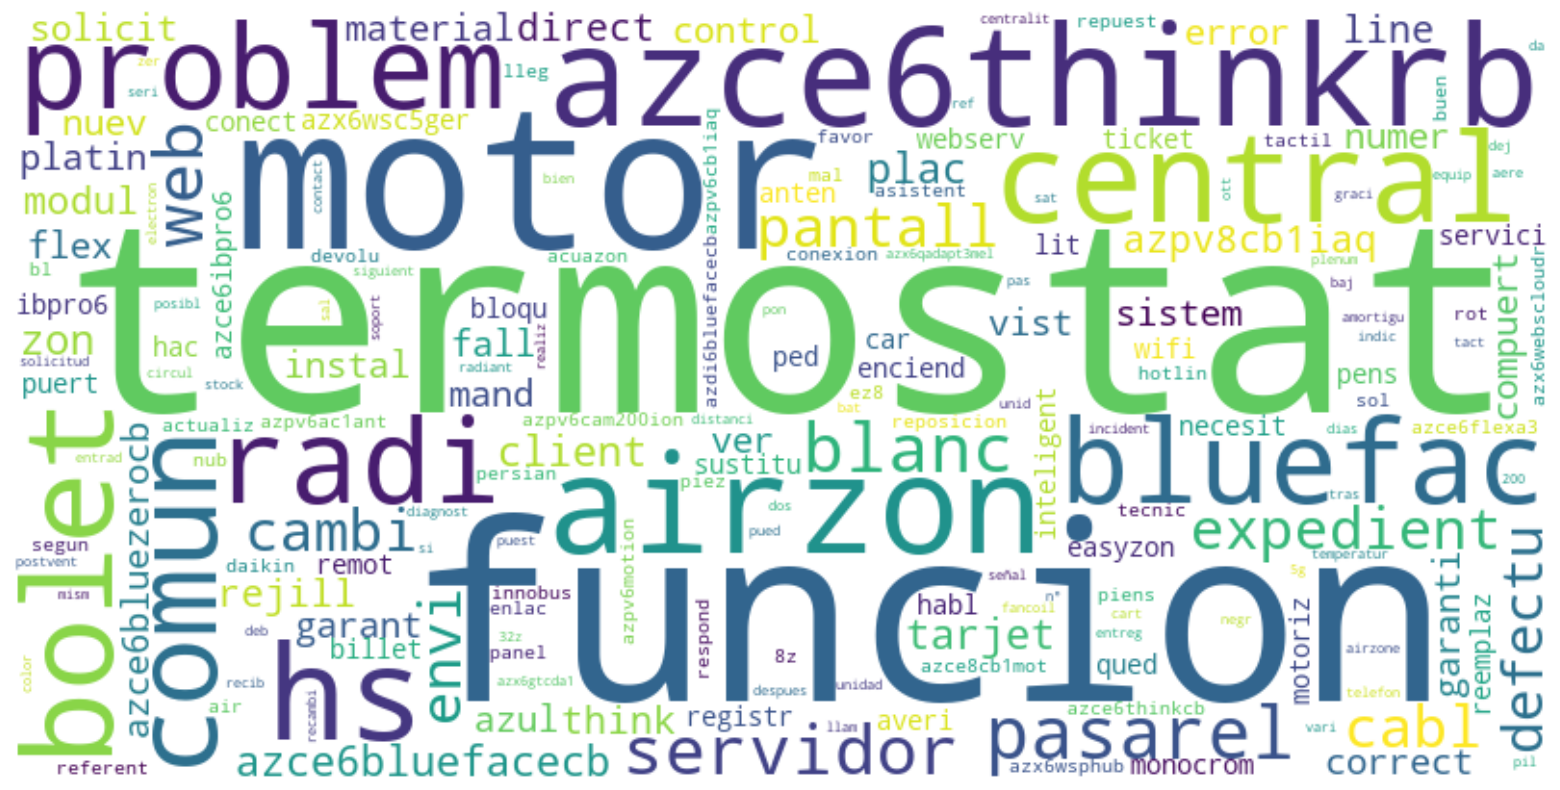

In [24]:
# Create a cloud of words with the most common words
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(vector.sum().to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

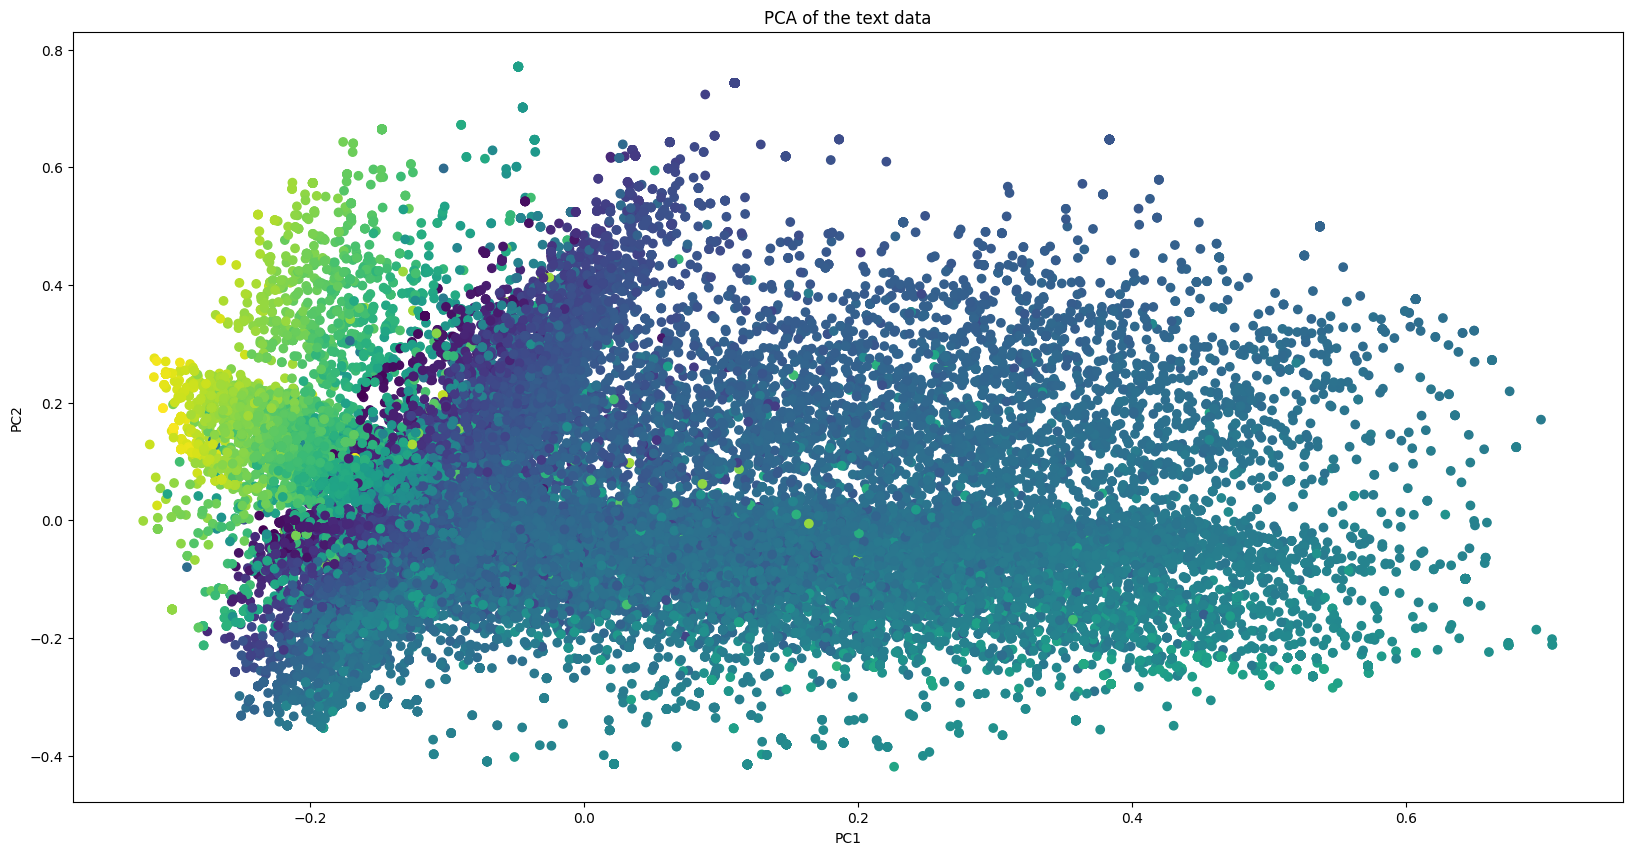

In [25]:
# Use PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_vector = pca.fit_transform(vector)
pca_vector = pd.DataFrame(pca_vector, columns=["PC1", "PC2", "PC3"])

plt.figure(figsize=(20, 10))
plt.scatter(pca_vector["PC1"], pca_vector["PC2"], c=pca_vector["PC3"], cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of the text data")
plt.show()

In [26]:
# Plotting in 3D
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    pca_vector["PC1"],
    pca_vector["PC2"],
    pca_vector["PC3"],
    c=pca_vector["PC3"],
    cmap="viridis",
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA of the text data")
plt.show()

In [27]:
%matplotlib inline

In [28]:
# Use another dimensionality reduction technique
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_vector = tsne.fit_transform(vector)
tsne_vector = pd.DataFrame(tsne_vector, columns=["TSNE1", "TSNE2", "TSNE3"])

In [54]:
%matplotlib qt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    tsne_vector["TSNE1"],
    tsne_vector["TSNE2"],
    tsne_vector["TSNE3"],
    c=tsne_vector["TSNE3"],
    cmap="viridis",
)
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
plt.title("TSNE of the text data")
plt.show()

In [48]:
# Check outliers
text_to_analyse.iloc[tsne_vector[tsne_vector["TSNE1"] > 75].index]

,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,cluster,temp_index
1745,dgkfäsld,,dfgdef,AZXCEEssdff,dgkfäsld dfgdef AZXCEEssdff,21,29
3448,ROTURA EN EL TRANSPORTE,,ROTURA POR EL TRANSPORTE,DIFUSOR LINEAL,ROTURA EN EL TRANSPORTE ROTURA POR EL TRANSPO...,21,77


In [46]:
%matplotlib inline

In [31]:
# Create a sklearn pipeline to apply a clustering algorithm
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([("kmeans", KMeans())])

# Create grid search parameters
parameters = {
    "kmeans__n_clusters": [
        75,
        80,
        95,
        100,
        105,
        110,
        115,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
    ]
}

grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=1)
grid_search.fit(vector)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=Pipeline(steps=[('kmeans', KMeans())]), n_jobs=-1,
             param_grid={'kmeans__n_clusters': [75, 80, 95, 100, 105, 110, 115,
                                                120, 130, 140, 150, 160, 170,
                                                180, 190, 200]},
             verbose=1)

In [32]:
# Check the best parameters
grid_search.best_params_

{'kmeans__n_clusters': 200}

In [33]:
# Add the cluster to the dataset
text_to_analyse["cluster"] = grid_search.best_estimator_.predict(vector)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\1956208197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse["cluster"] = grid_search.best_estimator_.predict(vector)


In [34]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    pca_vector["PC1"],
    pca_vector["PC2"],
    pca_vector["PC3"],
    c=text_to_analyse["cluster"],
    cmap="viridis",
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA of the text data")
plt.show()

In [35]:
# Plot the clusters
%matplotlib qt

# Plotting code
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    tsne_vector["TSNE1"],
    tsne_vector["TSNE2"],
    tsne_vector["TSNE3"],
    c=text_to_analyse["cluster"],
    cmap="viridis",
)
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
plt.title("After sales text clustering")
plt.show()

In [43]:
%matplotlib inline

In [37]:
text_to_analyse.head(10)

,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,cluster
0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,177
1,NO FUNCIONA,,NO FUNCIONA,AZC3TACTOCSB,NO FUNCIONA NO FUNCIONA AZC3TACTOCSB,14
2,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,115
3,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,121
4,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",35
5,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,9
6,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,9
7,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",161
8,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,188
9,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,188


In [38]:
text_to_analyse[text_to_analyse["cluster"] == 1]["problema_translated"]

53                   uno esta en negro y otro va muy lento
117                                  PANTALLA MANCHA NEGRA
463        se va a sustituir por una ccpc2 de reles negros
622      El termostato tiene una falla en la pantalla (...
623      El termostato tiene una falla en la pantalla (...
                               ...                        
42307     NO FUNCIONA EL SENSOR DEL TERMOSTATO DE RADIANT.
42697                     HS, pantalla completamente negra
42844       REFERENCIA A TOMAR DE NOSOTROS AZAI6BLUEZEROCB
45003                                          NO FUNCIONA
45407                                          No funciona
Name: problema_translated, Length: 239, dtype: object

In [39]:
# Create a temporary column 'temp_index' to assign a unique row identifier within each cluster
text_to_analyse["temp_index"] = text_to_analyse.groupby("cluster").cumcount()

# Pivot the DataFrame
pivoted_df = text_to_analyse.pivot(
    index="temp_index", columns="cluster", values="text_to_analyse"
)

# Optionally, if you don't want the multi-level index that comes from pivoting
pivoted_df.columns = [f"Cluster_{int(col)}" for col in pivoted_df.columns]

# Drop the index if it is irrelevant
pivoted_df.reset_index(drop=True, inplace=True)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_2788\4278190465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_to_analyse["temp_index"] = text_to_analyse.groupby("cluster").cumcount()


In [40]:
pivoted_df.head(50)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_190,Cluster_191,Cluster_192,Cluster_193,Cluster_194,Cluster_195,Cluster_196,Cluster_197,Cluster_198,Cluster_199
0,TEL PENSAR RADIO REF NOVOA HS\r\nSET comprado ...,2 blueface aza blanco empotrado. para sustitui...,SERVICIO WEB NUBE WIFI HORS REJILLA LINEAL CON...,ERROR 1 AZC3TACTOCSB 0000XDFD\r\nMOTOR DE EASY...,BOLETO 19345 JUNTA DE ADMINISTRACIÓN INNOBUS P...,VER EXPEDIENTE 15538 TARJETA WEB SERVIDOR NUBE...,BLUEFACE (AZCE6) SE RETRASA LA HORA OTT. CARA ...,RINT 500x150 no funciona motor. \r\n\r\nEnvio ...,Problemas de comunicación Platino para 6 Probl...,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,...,EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,ACTUALIZACIÓN DEL SHOWROOM DE PARÍS DE AZC3 A ...,MATERIALES PARA DEMOSTRACIÓN Y EXHIBICIÓN\r\nM...,Tras una cita con Cyril VEYSSIERE con uno de n...,1) Para asistencia MASSAS que ha cambiado a Na...,LA PANTALLA DEL TERMOSTATO QUEDA UNA PARTE EN ...,"SOLUCIONAR IMCOMPATIBILIDAD DE WS CON CCP, CON...",Malas cartas PLATINO IBP6 AZC3 tarjetas defect...,ENVIAR PARA REPOSICIÓN POR GARANTIA CENTRAL AQ...,Enviar puerta de enlace 8USW CON 8 ETC. MANDAR...
1,SISTEMA AIRZONE DESDE MAYO 2016\r\nGATEWAY FUN...,"TERMOSTATO TACTO CON MANCHA NEGRA EN PANTALLA,...",VISTO CON SERVICIO PLATINO IBP6 AZC3 VISTO CON...,Motor de amortiguador defectuoso REGISTRAR MOT...,BOLETO 22838 PAQUETE TERMOSTATO UN EXPEDIENTE ...,VER EXPEDIENTE N° 15195 = S/G DIRECTO SIN SOLI...,YA NO FUNCIONA TERMOSTATO INTELIGENTE CARA AZU...,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",Problemas de comunicación puerta de enlace de ...,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,...,EL TERMOSTATO RADIO E QUEDA BLOQUEADO. SE CONF...,ACTUALIZACIÓN DEL SHOWROOM DE PARÍS DE AZC3 A ...,Sobrecalentamiento aleatorio SERVIDOR WEB AIRZ...,Tras una cita con Cyril VEYSSIERE con uno de n...,1) Para asistencia MASSAS que ha cambiado a Na...,Dos de los mandos tactos ithink colr blanco se...,15 TAPAS BLANCAS TAPAS TRASERAS BLANCAS 15 UNI...,TARJETA HS CARTA CARTA AZC3FIBPR06,ENVIAR PARA REPOSICIÓN POR GARANTIA CENTRAL AQ...,Enviar puerta de enlace 8USW CON 8 ETC. MANDAR...
2,PROBLEMA AFICHAGE TERMOSTATO PENSAR RADIO TERM...,necesitamos una ccpc2 de reles negros y un wsc...,VISTO CON SERVICIO PASARELA LG PARA IBP6 AZC3 ...,MOTORES PROVENIENTES DE PARTIDA DEFECTUOSA (CO...,BOLETO 32409 JUNTA DIRECTIVA DE INNOBUS BOLETO...,VER EXPEDIENTE DE SERVICIO N° 19766 TARJETA WE...,LA MÁQUINA NO SE DETIENE AUN CUANDO SE ALCANZA...,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",Termostatos: fallo en display HS\r\nPlatino: p...,Cuando se activa el AZAMFANCOILC el Blueface s...,...,Rogamos nos envíen un RMA para un módulo de f...,Un THINK cable y un THINK radio de dos instala...,cambiar de AZC3 a AZC6 para detectar un proble...,Tras una cita con Cyril VEYSSIERE con uno de n...,Avance de material para servicio postventa dur...,Dos de los mandos tactos ithink colr blanco se...,15 TAPAS BLANCAS TAPAS TRASERAS BLANCAS 15 UNI...,cartas hs\r\nAZC3FIBTR06 y AZCE6IBPRO6 tarjeta...,NO GARANTIA. PEDIDO DE REPOSICION DE MATERIAL ...,Sobrecalentamiento: es necesario realizar un r...
3,CF GUARDAR ARCHIVO 16748 TERMOSTATO PENSAR RAD...,Tras la sustitución del sistema - en el moment...,visto con servicio postventa POR DEFECTO AZXW...,MOTORES PROVENIENTES DE PARTIDA DEFECTUOSA (CO...,Intercambio telefónico entre el representante ...,VER EXPEDIENTE N° 22292 TARJETA WEB SERVIDOR N...,OTT. SERIE BF EN SOLITARIO OTT. CARA AZUL BL (...,"3Ud MINT Y 1 Ud MAIR, ruido al cerrar (crac, c...",Termostatos: fallo en display HS\r\nPlatino: p...,Cuando se activa el AZAMFANCOILC el Blueface s...,...,LAS 3 CENTRALES IB PRO32 DE LA MISMA INSTALACI...,Fallo Piensa Radio Termostato Think radio Envi...,GAMA DE REEMPLAZO 2013 A 2016 PARA ÁREA ADICIO...,Tras una cita con Cyril VEYSSIERE con uno de n...,Avance de material para servicio postventa dur...,"LA PANTA

In [41]:
clean_dataset.head()

,id,web_id,codigo,creation_date,modification_date,company_id,user_id,ref_cliente,portes_airzone,devaluacion,...,titulo_en_tipo,titulo_fr_tipo,titulo_it_tipo,titulo_pt_tipo,desc_problema_lg,desc_problema_translated,descripcion_lg,descripcion_translated,problema_lg,problema_translated
0,49,1,YZ2YZZUU16,2015-04-27 09:32:18,2015-05-28 06:55:45,498,128.0,CENTRAL ALARMAS,1,0,...,guarantee,garantie,garanzia,None,es,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,es,MODULO ALARMAS TECNICAS,es,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...
1,5,1,Y52FA5OT97,2015-03-10 17:49:28,2015-04-16 16:51:24,26,67.0,21406866,1,0,...,guarantee,garantie,garanzia,None,es,NO FUNCIONA,NaN,NaN,es,NO FUNCIONA
2,50,1,ZP2CZZYVBD,2015-04-27 09:51:49,2015-06-03 09:09:08,499,117.0,SPLITMANIA JEREZ-ANTONIO GARCIA PADILLA,1,0,...,guarantee,garantie,garanzia,None,es,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,NaN,es,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...
3,46,1,YPUEA5WZ10,2015-04-20 14:44:57,2015-05-28 06:21:09,498,128.0,REPARACION MODULO PERSIANA,1,0,...,guarantee,garantie,garanzia,None,es,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,pt,MODELO 2 PERSIANAS,es,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...
4,51,1,ZPWBA5ETF7,2015-04-27 14:49:58,2015-05-13 16:33:58,497,135.0,"REJILLA DE JESUS VELASCO, SPLITMANIA HUELVA",1,0,...,guarantee,garantie,garanzia,None,es,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,NaN,es,Rafael el viernes llego mi pedido nº 23349 pa...


In [42]:
clean_dataset.groupby(["cod_articulo"]).size().sort_values(ascending=False)

cod_articulo
AZCE6THINKRB       4085
AZCE6BLUEFACECB    3150
AZPV8CB1IAQ        1642
AZX6WSC5GER        1133
AZCE6BLUEZEROCB    1131
                   ... 
AZPVRXGREE            1
AZPVRXFGI2            1
AZPVRXFGI1            1
AZPVOWR1BRN5P38       1
à définir             1
Length: 7259, dtype: int64

## Calculate error

In [62]:
# Read list of errors
errors = pd.read_csv("../DATA/TablaTipoErrorPostventa.csv", sep=";", header=0)[
    ["Código", "CODCAR3", "CODCAR2", "DESCFAM", "Motivo General", "DESCRIPCION"]
]
errors.columns = [
    "ID_ERROR",
    "CODCAR3",
    "CODCAR2",
    "DESCFAM",
    "MOTIVO",
    "DESCRIPCION",
]  # Rename columns
# Fill NA with empty string
errors['DESCRIPCION'] = errors['DESCRIPCION'].fillna('')
errors["DESCRIPCION"] = (
    errors["MOTIVO"] + " " + errors["DESCRIPCION"]
)  # Concatenate MOTIVO and DESCRIPCION
errors["CODCAR2"] = errors["CODCAR2"].str.replace("-", "0").astype(int)  # Clean CODCAR2

In [75]:
# Transform the 'DESCRIPCION' column using the vectorizer (returns a sparse matrix)
description_sparse = vectorizer.transform(errors["DESCRIPCION"])

# Convert the vector to a DataFrame
error_vector = pd.DataFrame(description_sparse.toarray(), columns=vectorizer.get_feature_names_out())

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_cosine_score(vector, vector_error):
    return cosine_similarity(vector.reshape(1, -1), vector_error.reshape(1, -1))[0][0]


def calculate_mean_cosine_score(vector, vector_error, n=5):
    if vector.size == 0 or vector_error.size == 0:
        return np.nan  # Return NaN if there's no vector to compare
    cosine_scores = []
    for i in range(n):
        cosine_scores.append(calculate_cosine_score(vector, vector_error))
    return np.mean(cosine_scores)